# Kronecker-based Compressed Sensing signal recovery

In this notebook we explore the _compression_ and _recovery_ of aCompressive Sensing _compressible_ signal through __Compressive Sensing__ with __Kronecker Technique__

#### Utilities

In [14]:
import numpy as np

def printFormatted(matrix, decimals=4):
    """
    Prints the matrix with formatted elements aligned in columns for improved readability.

    Parameters:
    ----------
    matrix : numpy array
        The matrix to be printed.
    decimals : int, optional (default=4)
        The number of decimal places for formatting the elements.

    Returns:
    -------
    None
        This function does not return any value; it prints the formatted matrix directly to the console.

    Notes:
    -----
    - The function aligns columns based on the maximum width needed for the formatted elements, ensuring the matrix is displayed neatly.
    - This function is useful for visual inspection of numerical matrices, especially those with varying magnitudes.
    
    Example:
    --------
    >>> import numpy as np
    >>> matrix = np.array([[1.234567, 123.456789], [0.0001234, 1.2345]])
    >>> print('Classic print:')
    >>> print(matrix)
    Classic print:
    [[1.2345670e+00 1.2345679e+02]
     [1.2340000e-04 1.2345000e+00]]
     
    >>> print('\nFormatted print:')
    >>> printFormatted(matrix, decimals=4)
         1.2346  123.4568
         0.0001    1.2345
    
    """

    # Determine the maximum width needed to keep alignment
    max_width = max(len(f'{value:.{decimals}f}') for row in matrix for value in row)

    # Create a formatted string for each element in the matrix, ensuring alignment
    formatted_matrix = '\n'.join([' '.join([f'{value:>{max_width}.{decimals}f}' for value in row]) for row in matrix])

    # Print the formatted matrix
    print(formatted_matrix)


### Generate a random sparse signal

In [15]:
import numpy as np

def sparseSignal(N, K=None, sigma_inactive=0.01, sigma_active=0.5, fixedActiveValue=None):
    """
    Generates a K-sparse signal with N-K inactive components, chosen randomly. The inactive components 
    are nearly zero, while the active components are either a fixed value or generated from a Gaussian
    distribution.

    Parameters:
    ----------
    N : int
        The total number of components in the signal.
    
    K : int, optional
        The number of active (non-zero) components in the signal. If not provided, defaults to 10% of `N`.
    
    sigma_inactive : float, optional (default=0.01)
        The standard deviation of the Gaussian noise added to the inactive components.
    
    sigma_active : float, optional (default=0.5)
        The standard deviation of the Gaussian noise for generating the active components, if `fixedActiveValue` 
        is not provided.
    
    fixedActiveValue : float, optional
        If provided, this fixed value is assigned to all active components instead of generating them randomly.

    Returns:
    -------
    signal : numpy array
        The generated signal of length `N` with `K` active components.
    
    active_indices : numpy array
        The indices of the active components in the signal.

    Notes:
    -----
    - The signal is constructed by first randomly selecting `K` indices as active components.
    - If `fixedActiveValue` is `None`, the active components are drawn from a Gaussian distribution 
      with standard deviation `sigma_active`.
    - Gaussian noise with standard deviation `sigma_inactive` is then added to the inactive components, 
      ensuring they have small random values near zero.

    Example:
    --------

    >>> signal, active_indices = sparseSignal(10, K=3, sigma_inactive=0.01, sigma_active=0.5)
    >>> print(signal)
    [ 0.          0.          0.          0.          0.          0.          0.
      0.          0.          0.45470039]
    >>> print(active_indices)
    [9]

    """

    if K is None:
        N = int(N)
        K = int(0.1 * N)
    else:
        N = int(N)
        K = int(K)

    active_indexes = np.zeros(N)
    active_indexes[:K] = 1
    np.random.shuffle(active_indexes)

    signal = np.zeros(N)
    
    if fixedActiveValue is None:
        # Generate active components with Gaussian noise
        signal[active_indexes == 1] = np.random.randn(K) * sigma_active
    else:
        # Use fixed value for active components
        signal[active_indexes == 1] = fixedActiveValue
    
    # Add Gaussian noise only to inactive components
    signal[active_indexes == 0] += np.random.randn(N - K) * sigma_inactive

    return signal, np.where(active_indexes == 1)[0]


#### Measurement matrix

In [16]:
import numpy as np

def generate_DBDD_matrix(M, N):
    """
    Generates a deterministic Diagonally Blocked Block Diagonal (DBBD) matrix.

    A DBBD matrix is a type of block diagonal matrix where each block is a square diagonal matrix.

    Parameters
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix. Should be a multiple of M.

    Returns
    -------
    A : numpy.ndarray
        The generated DBBD matrix of shape (M, N).

    Raises
    ------
    ValueError
        If `N` is not a multiple of `M`.

    Example
    -------
    >>> generate_DBDD_matrix(3, 9)
    array([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 1., 1., 1., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 1., 1.]])
    """


    if N % M != 0:
        raise ValueError("N should be a multiple of M.")
    
    Phi = np.zeros((M, N))
    m = N // M
    
    for i in range(M):
        Phi[i, i*m:(i+1)*m] = 1

    return Phi


def generate_random_matrix(M, N, matrix_type='gaussian'):
    """
    Generates a random matrix based on the specified type.

    Parameters
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix.
    matrix_type : str, optional (default='gaussian')
        The type of random matrix to generate. Options are:
        - 'gaussian': A matrix with entries drawn from a normal distribution scaled by 1/M.
        - 'scaled_binary': A matrix with binary entries (±0.5), scaled by 1/sqrt(M).
        - 'unscaled_binary': A matrix with binary entries (±1), with no scaling.

    Returns
    -------
    A : numpy.ndarray
        The generated random matrix of shape (M, N).

    Raises
    ------
    ValueError
        If `matrix_type` is not one of the supported types.

    Example
    -------
    >>> generate_random_matrix(2, 3, matrix_type='gaussian')
    array([[ 0.01, -0.02,  0.03],
           [-0.04,  0.05, -0.06]])

    >>> generate_random_matrix(2, 3, matrix_type='scaled_binary')
    array([[-0.5,  0. , -0.5],
           [ 0.5, -0.5,  0. ]])
    
    >>> generate_random_matrix(2, 3, matrix_type='unscaled_binary')
    array([[ 1., -1.,  1.],
           [-1.,  1., -1.]])
    """
    if matrix_type == 'gaussian':
        A = ((1/M)**2) * np.random.randn(M, N)

    elif matrix_type == 'scaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) - 0.5
        A = (1/np.sqrt(M)) * A

    elif matrix_type == 'unscaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) * 2 - 1

    else:
        raise ValueError("Unsupported matrix type. Choose either 'gaussian', 'scaled_binary', or 'unscaled_binary'.")

    return A




In [17]:
N = 2 ** 4
M = N // 4

# Generate a deterministic DBBD matrix
A = generate_DBDD_matrix(M, N)
print('DBDD:')
printFormatted(A)

# Generate a random Gaussian matrix
B = generate_random_matrix(M, N, matrix_type='gaussian')
print('Gaussian:')
printFormatted(B)


# Generate a random scaled binary matrix
C = generate_random_matrix(M, N, matrix_type='scaled_binary')
print('Scaled binary:')
printFormatted(C)

# Generate a random unscaled binary matrix
D = generate_random_matrix(M, N, matrix_type='unscaled_binary')
print('Unscaled binary:')
printFormatted(D)


DBDD:
1.0000 1.0000 1.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.0000 0.0000 0.0000 0.0000 1.0000 1.0000 1.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 1.0000 1.0000 1.0000 0.0000 0.0000 0.0000 0.0000
0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 1.0000 1.0000 1.0000
Gaussian:
-0.0639 -0.0647  0.0275 -0.0309 -0.0639 -0.0887 -0.0805 -0.0564  0.0478  0.0638 -0.0319 -0.0839  0.0128  0.0396 -0.0314 -0.0173
-0.0242  0.0245 -0.0530 -0.0557 -0.0442  0.0330  0.0716 -0.0483  0.1150 -0.0255  0.0984  0.0009 -0.0335  0.0073 -0.0912 -0.0113
 0.0370  0.0425 -0.0289  0.1059  0.0319 -0.0397 -0.0641  0.0281 -0.0611 -0.0371  0.0660  0.0595 -0.0358  0.0338 -0.0422 -0.0738
-0.1190  0.0296 -0.0367  0.0155  0.0548 -0.0034  0.0839  0.0191 -0.0595  0.1178 -0.0432  0.0048  0.0198 -0.0934 -0.0410 -0.0624
Scaled binary:
 0.2500 -

#### Generate dictionary

In [18]:
import numpy as np
import scipy.fftpack as fftpack
import pywt

def generate_dct_dictionary(N):
    """
    Generates a Discrete Cosine Transform (DCT) orthonormal basis matrix.

    The DCT basis is commonly used in signal processing and data compression. 
    It transforms a signal into a sum of cosine functions oscillating at different frequencies. 
    The resulting matrix can be used for orthogonal transformations of signals.
    
    DCT basis is sparifying.
    

    Parameters
    ----------
    N : int
        The size of the dictionary (i.e., the length of the signal).

    Returns
    -------
    dict_matrix : numpy.ndarray
        The generated DCT dictionary matrix of shape (N, N), where each column represents 
        a DCT basis vector.

    Example
    -------
    >>> generate_dct_dictionary(4)
    array([[ 0.5       ,  0.5       ,  0.5       ,  0.5       ],
           [ 0.65328148,  0.27059805, -0.27059805, -0.65328148],
           [ 0.5       , -0.5       , -0.5       ,  0.5       ],
           [ 0.27059805, -0.65328148,  0.65328148, -0.27059805]])
    """
    
    # Generate a DCT basis dictionary
    dict_matrix = fftpack.dct(np.eye(N), norm='ortho')    
    return dict_matrix



def generate_dwt_basis(dim, wavelet='db5', mode='per', level=None):
    """

    BEWARE: This function is not working properly!
    - Result matrix is orthonormal, but doesn't work for compressed sensing! So it's not computing
       the correct dictionary ...



    Generates a wavelet orthonormal basis matrix using the Discrete Wavelet Transform (DWT).

    The wavelet basis matrix is useful in signal processing, where it is used for analyzing
    and reconstructing signals. Each column of the matrix represents a wavelet basis vector 
    for the specified wavelet type and decomposition level.

    Parameters
    ----------
    dim : int
        The dimension of the basis (i.e., the length of the signal and the size of the matrix).
    
    wavelet : str, optional (default='db5')
        The name of the wavelet to use. Options include Daubechies wavelets ('db1' to 'db20') and
        other wavelet families available in PyWavelets.

    mode : str, optional (default='per')
        The signal extension mode to use when applying the wavelet transform. The default is
        'per' for periodic extension. Other options include 'zero', 'symmetric', etc.

    level : int, optional
        The level of decomposition to perform. If not provided, the function defaults
        to the maximum level, which is log2(dim). If a value is provided, it must be 
        an integer greater than 0 and not exceed log2(dim).

    Returns
    -------
    basis_matrix : numpy.ndarray
        The generated wavelet basis matrix of shape (dim, dim). Each column of this matrix 
        represents a wavelet basis vector for the given wavelet and decomposition level.

    Raises
    ------
    ValueError
        If `dim` is not a power of 2, or if `level` is not an integer greater than 0.

    Notes
    -----
    - The function assumes that `dim` is a power of 2. If not, a ValueError is raised.
    - If `level` is not provided, the function sets it to log2(dim) for a full decomposition.
    - The basis matrix is constructed by applying the wavelet transform to each standard 
      basis vector (i.e., the columns of the identity matrix) and concatenating the resulting 
      coefficients into the final basis matrix.

    Example
    -------
    >>> generate_dwt_basis(8, wavelet='db1', mode='symmetric')
    array([[ 0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339,  0.35355339],
           [ 0.35355339,  0.35355339, -0.35355339, -0.35355339,  0.35355339,  0.35355339, -0.35355339, -0.35355339],
           [ 0.5       , -0.5       ,  0.        ,  0.        ,  0.5       , -0.5       ,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  0.5       , -0.5       ,  0.        ,  0.        ,  0.5       , -0.5       ],
           [ 0.70710678, -0.70710678,  0.        ,  0.        , -0.70710678,  0.70710678,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  0.70710678, -0.70710678,  0.        ,  0.        , -0.70710678,  0.70710678],
           [ 0.70710678,  0.70710678,  0.        ,  0.        , -0.70710678, -0.70710678,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  0.70710678,  0.70710678,  0.        ,  0.        , -0.70710678, -0.70710678]])
    """

    # Check if the dimension is a power of 2
    if not np.log2(dim).is_integer():
        raise ValueError("Dimension must be a power of 2.")

    # Check if level is provided and valid
    if level is None:
        print("Level is not provided, setting level to log2(dim)")
        level = int(np.log2(dim))
    elif level < 1:
        raise ValueError("Level must be an integer greater than 0.")
    elif level > int(np.log2(dim)):
        print("Level provided is greater than max_level=log2(dim); setting level to log2(dim).")
        level = int(np.log2(dim))

    # Initialize the basis matrix
    basis_matrix = np.zeros((dim, dim))
    
    for i in range(dim):
        # Apply wavelet transform to each basis vector
        coeffs = pywt.wavedec(data=np.eye(dim)[:, i], wavelet=wavelet, mode=mode, level=level, axis=0)
        
        # Flatten the coefficients and assign to the corresponding column in the basis matrix
        basis_matrix[:, i] = np.hstack(coeffs)
    
    return basis_matrix


In [19]:
def compute_independent_columns(A, tol=1e-10):
    """
    Computes the independent columns of a matrix using the QR decomposition.

    The function identifies independent columns of a given matrix `A` by performing a QR 
    decomposition. It selects columns corresponding to non-zero diagonal elements of the 
    `R` matrix, which are considered linearly independent.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix for which to compute the independent columns.
    tol : float, optional (default=1e-10)
        The tolerance value for considering diagonal elements of `R` as non-zero.

    Returns
    -------
    ind_cols : numpy.ndarray
        A matrix containing the independent columns of `A`.

    Notes
    -----
    - The QR decomposition is used to determine the rank of the matrix `A`.
    - Columns corresponding to non-zero diagonal elements of the `R` matrix are considered independent.

    Example
    -------
    >>> A = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> compute_independent_columns(A)
    array([[1, 2],
           [4, 5],
           [7, 8]])
    """
    # Perform the QR decomposition
    Q, R = np.linalg.qr(A)

    # Find the independent columns based on the rank of R
    rank = np.sum(np.abs(np.diagonal(R)) > tol)
    ind_cols = A[:, :rank]

    return ind_cols

def check_normalization(A):
    """
    Checks if the columns of a matrix are normalized (i.e., each column has a unit norm).

    The function calculates the norm of each column in the matrix `A` and checks if all 
    column norms are close to 1.0, which indicates normalization.

    Parameters
    ----------
    A : numpy.ndarray
        The matrix to check for normalization.

    Returns
    -------
    is_normalized : bool
        True if all columns of `A` are normalized, False otherwise.

    Example
    -------
    >>> A = np.array([[1, 0], [0, 1]])
    >>> check_normalization(A)
    True
    """
    column_norms = np.linalg.norm(A, axis=0)
    is_normalized = np.allclose(column_norms, 1.0)
    return is_normalized

def compute_coherence(matrix):
    """
    Computes the coherence of the given matrix.

    Coherence is a measure of the maximum correlation between any two columns of a matrix. 
    It is useful in various applications, such as signal processing and compressed sensing, 
    to assess the degree of similarity between different columns of the matrix.

    Parameters
    ----------
    matrix : numpy.ndarray
        An N x M matrix where coherence is to be calculated.

    Returns
    -------
    coherence : float
        The coherence of the matrix, defined as the maximum absolute value of the off-diagonal 
        elements in the Gram matrix of the column-normalized input matrix.

    Example
    -------
    >>> matrix = np.array([[1, 0], [0, 1]])
    >>> compute_coherence(matrix)
    0.0
    """
    # Normalize the columns of the matrix
    normalized_matrix = matrix / np.linalg.norm(matrix, axis=0, keepdims=True)
    
    # Compute the Gram matrix (inner products between all pairs of columns)
    gram_matrix = np.dot(normalized_matrix.T, normalized_matrix)
    
    # Remove the diagonal elements (which are all 1's) to only consider distinct columns
    np.fill_diagonal(gram_matrix, 0)
    
    # Compute the coherence as the maximum absolute value of the off-diagonal elements
    coherence = np.max(np.abs(gram_matrix))
    
    return coherence


In [20]:
DIM = 16

# Generate dictionary
A = generate_dct_dictionary(DIM)  # test what you want
print(f'Dictionary shape: {A.shape}')
print()

# Orthonormality test
print("Orthonormality test")

# Check orthogonality
rankA = np.linalg.matrix_rank(A)
#print(f'Rank of A: {rankA}')
if A.shape[0] == rankA or A.shape[1] == rankA:
    print("Matrix A is full rank.")

# Check normalization
is_normalized = check_normalization(A)
print(f"Matrix A is normalized: {is_normalized}")
is_normalized = check_normalization(A.T)
print(f"Matrix A^T is normalized: {is_normalized}")
print()

# Coherence test
print("Coherence test")
coherence = compute_coherence(A)
print(f'Coherence: {coherence}')


Dictionary shape: (16, 16)

Orthonormality test
Matrix A is full rank.
Matrix A is normalized: True
Matrix A^T is normalized: True

Coherence test
Coherence: 1.670992254306886e-16


#### Sampling Phase

In [21]:
def compressSignal(signal, Phi):
    """
    Performs the sampling phase of Compressed Sensing (CS) by compressing a signal using a provided measurement matrix.

    In the context of Compressed Sensing, this function takes an input signal and a measurement matrix (Phi) and 
    compresses the signal into smaller blocks. Each column of the output matrix `Y` represents the compressed 
    measurement of a block of the input signal. The measurement matrix `Phi` is used to sample the signal in a way 
    that allows for efficient reconstruction from fewer samples than traditional Nyquist sampling would require.

    Parameters
    ----------
    signal : numpy.ndarray
        The original signal to be compressed, represented as a 1-dimensional array.
    
    Phi : numpy.ndarray
        The measurement matrix used for compressed sensing, of shape (M, N), where:
        - M is the number of measurements (rows of the compressed signal).
        - N is the length of each block of the original signal to be sampled.

    Returns
    -------
    Y : numpy.ndarray
        The compressed signal matrix of shape (M, BLOCK_NUM), where BLOCK_NUM is the 
        number of non-overlapping blocks created by dividing the length of the input signal by `N`.

    Notes
    -----
    - The function processes the input signal in non-overlapping blocks of length `N`. If the length of the signal 
      is not an exact multiple of `N`, the remaining samples at the end of the signal that do not fit into a full 
      block are ignored.
    - The measurement matrix `Phi` should have a number of columns (N) less than or equal to the length of the signal.
      If `Phi` has more columns than the length of the signal block, a `ValueError` will be raised due to a shape mismatch.
    - This function is a key step in the sampling phase of Compressed Sensing, where a sparse signal is projected 
      into a lower-dimensional space using random or structured measurements.
    """
    
    # length of signal block
    N = Phi.shape[1]

    # length of compressed block
    M = Phi.shape[0]

    # number of blocks
    BLOCK_NUM = len(signal) // N

    # each column of Y is the compressed version of a block of signal
    Y = np.zeros((M, BLOCK_NUM))    
    for i in range(BLOCK_NUM):
        Y[:,i] = Phi @ signal[i*N:(i+1)*N]
    
    return Y


#### Reconstruction method: Smooth-L0 (SL0)

In [22]:
import numpy as np

def SL0(y, A, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, showProgress=False):
    """
    Returns the sparsest vector `s` that satisfies the underdetermined system of 
    linear equations `A @ s = y`, using the Smoothed L0 (SL0) algorithm.

    Requires:
    --------
    - numpy as np
    

    Parameters:
    ----------
    y : numpy array
        The observed vector (Mx1), where M is the number of rows in `A`.
    
    A : numpy array
        The measurement matrix (MxN), which should be 'wide', meaning it has more 
        columns than rows (N > M). The number of rows in `A` must match the length 
        of `y`.
    
    sigma_min : float
        The minimum value of `sigma`, which determines the stopping criterion for 
        the algorithm. It should be chosen based on the noise level or desired 
        accuracy.
    
    sigma_decrease_factor : float, optional (default=0.5)
        The factor by which `sigma` is decreased in each iteration. This should be 
        a positive value less than 1. Smaller values lead to quicker reduction of 
        `sigma`, possibly at the cost of accuracy for less sparse signals.
    
    mu_0 : float, optional (default=2)
        The scaling factor for `mu`, where `mu = mu_0 * sigma^2`. This parameter 
        influences the convergence rate of the algorithm.
    
    L : int, optional (default=3)
        The number of iterations for the inner loop (steepest descent). Increasing 
        `L` can improve the precision of the result but also increases computational 
        cost.
    
    A_pinv : numpy array, optional
        The precomputed pseudoinverse of the matrix `A`. If not provided, it will be 
        calculated within the function as `np.linalg.pinv(A)`. Providing this value 
        is beneficial if the function is called repeatedly with the same `A`.
    
    showProgress : bool, optional (default=False)
        If `True`, the function prints the current value of `sigma` during each 
        iteration, which helps monitor the convergence process.

    Returns:
    -------
    s : numpy array
        The estimated sparse signal (Nx1) that best satisfies the equation `A @ s = y`.

    Notes:
    -----
    - The algorithm works by iteratively reducing `sigma` in a geometric sequence, 
      starting with `sigma = 2 * max(abs(s))` and ending with `sigma_min`. At each 
      step, the function adjusts `s` to minimize the L0-norm by smoothing it using 
      a Gaussian kernel.
    
    - The choice of `sigma_min` is crucial: for noiseless cases, a smaller `sigma_min` 
      yields a sparser solution; for noisy cases, `sigma_min` should be a few times 
      the standard deviation of the noise in `s`.

    - If `A_pinv` is precomputed and passed as an argument, the function becomes 
      more efficient, especially in scenarios where it is called repeatedly with the 
      same `A`.

    """

    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)

    # Initialize the variables
    s = A_pinv @ y
    sigma = 2 * max(np.abs(s))

    # Define lambda function for delta
    OurDelta = lambda s, sigma: s * np.exp(-s**2 / sigma**2)
 
    # Main loop
    while sigma > sigma_min:
        for i in range(L):
            delta = OurDelta(s, sigma)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y)
        
        if showProgress:
            print(f'sigma: {sigma}')

        sigma = sigma * sigma_decrease_factor

    return s


#### Recovery

Non-kronecker

In [23]:
import os

def non_kron_recovery(Y, sigma_min, Phi, sigma_decrease_factor=0.5, mu_0=2, L=3, showProgress=False):

    n_block = Phi.shape[1]  # length of ORIGINAL signal block
    Dict = generate_dct_dictionary(n_block)  # Dictionary
    Theta = Phi @ Dict  # Theta
    Theta_pinv = np.linalg.pinv(Theta)  # More-Penrose pseudoinverse of Theta
    BLOCK_NUM = Y.shape[1]  # number of blocks

    n_block = Theta.shape[1]  # length of ORIGINAL signal block

    # Prepare output files
    output_dir = 'debugCsvPy'  # Directory where CSV files will be stored
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define file paths
    y_block_path = os.path.join(output_dir, 'y_block.csv')
    s_block_path = os.path.join(output_dir, 's_block.csv')

    # Delete files if they exist
    if os.path.exists(y_block_path):
        os.remove(y_block_path)
    if os.path.exists(s_block_path):
        os.remove(s_block_path)

    # Initialize the recovered signal
    x_hat = np.zeros(BLOCK_NUM * n_block)  # Recovered signal will be as long as the original signal

    # Process each block
    for i in range(BLOCK_NUM):
        y = Y[:, i]
        s_block = SL0(y, Theta, sigma_min, sigma_decrease_factor, mu_0, L, Theta_pinv, showProgress)
        x_hat[i*n_block:(i+1)*n_block] = Dict @ s_block

        # Append y to y_block.csv
        with open(y_block_path, 'a') as f_y:
            np.savetxt(f_y, y.reshape(1, -1), delimiter=',', fmt='%.6f')

        # Append s_block to s_block.csv
        with open(s_block_path, 'a') as f_s:
            np.savetxt(f_s, s_block.reshape(1, -1), delimiter=',', fmt='%.6f')
        

    # DEBUGGING
    np.savetxt(f'{output_dir}/A1_Theta.csv', Theta, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/dict1_Dict.csv', Dict, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/A_pinv1.csv', Theta_pinv, delimiter=',', fmt='%.6f')


    return x_hat


Kronecker-based

In [24]:
import os
import numpy as np


def kron_recovery(Y, sigma_min, Phi, kron_factor, sigma_decrease_factor=0.5, mu_0=2, L=3, showProgress=False):



    Phi_kron = np.kron(np.eye(kron_factor), Phi)  # KRONECKER product of Phi (kroncker measurement matrix)

    n_block = Phi.shape[1]  # length of ORIGINAL signal block
    #m_block = Phi.shape[0]  # length of compressed signal block
    n_block_kron = Phi_kron.shape[1]  # length of ORIGINAL signal KRONECKER-block
    #m_block_kron = Phi_kron.shape[0]  # length of compressed signal KRONECKER-block

    BLOCK_NUM = Y.shape[1]  # number of blocks
    N = n_block * BLOCK_NUM  # length of ORIGINAL signal
    KRON_BLOCK_NUM = N // n_block_kron  # number of KRONECKER blocks

    Dict_kron = generate_dct_dictionary(n_block_kron)  # Dictionary (kron)
    Theta_kron = Phi_kron @ Dict_kron  # Theta (kron)
    Theta_kron_pinv = np.linalg.pinv(Theta_kron)  # More-Penrose pseudoinverse of Theta (kron)


    
    # Prepare output files
    output_dir = 'debugCsvPy'  # Directory where CSV files will be stored
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define file paths
    y_concatenated_path = os.path.join(output_dir, 'y_concatenated.csv')
    s_block_kron_path = os.path.join(output_dir, 's_block_kron.csv')

    # Delete files if they exist
    if os.path.exists(y_concatenated_path):
        os.remove(y_concatenated_path)
    if os.path.exists(s_block_kron_path):
        os.remove(s_block_kron_path)

    # Initialize the recovered signal
    x_hat_kron = np.zeros(N)

    # Process each block
    # DO NOT FORGET MATLAB IS COL-MAJOR, PY IS ROW-MAJOR, that darn 'F'... took my a day to figure out
    for i in range(KRON_BLOCK_NUM):
        y_kron = Y[:, i*kron_factor:(i+1)*kron_factor].reshape(-1, order='F')

        # Print y_kron shape (for debugging)
        #print(f'y_kron shape: {y_kron.shape}')
        #print(y_kron)
        #print('---')

        s_kron_block = SL0(y_kron, Theta_kron, sigma_min, sigma_decrease_factor, mu_0, L, Theta_kron_pinv, showProgress)
        x_hat_kron[n_block_kron*i:(i+1)*n_block_kron] = Dict_kron @ s_kron_block

        # Append y_kron to y_concatenated.csv
        with open(y_concatenated_path, 'a') as f_y_kron:
            np.savetxt(f_y_kron, y_kron.reshape(1, -1), delimiter=',', fmt='%.6f')
            # Write a line of zeros to separate blocks
            np.savetxt(f_y_kron, np.zeros_like(y_kron.reshape(1, -1)), delimiter=',', fmt='%.6f')

        # Append s_kron_block to s_block_kron.csv
        with open(s_block_kron_path, 'a') as f_s_kron:
            np.savetxt(f_s_kron, s_kron_block.reshape(1, -1), delimiter=',', fmt='%.6f')
            # Write a line of zeros to separate blocks
            np.savetxt(f_s_kron, np.zeros_like(s_kron_block.reshape(1, -1)), delimiter=',', fmt='%.6f')

    # DEBUGGING
    np.savetxt(f'{output_dir}/AA_Phi_kron.csv', Phi_kron, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/A2_Theta_kron.csv', Theta_kron, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/dict2_Dict_kron.csv', Dict_kron, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/A_pinv2.csv', Theta_kron_pinv, delimiter=',', fmt='%.6f')
    


    return x_hat_kron




#### Evaluation of results

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_snr(signal, recovered_signal):
    """
    Calculates the Signal-to-Noise Ratio (SNR) between the original signal and the recovered signal.

    Parameters
    ----------
    signal : numpy.ndarray
        The original signal.
    recovered_signal : numpy.ndarray
        The recovered signal after some processing or recovery algorithm.

    Returns
    -------
    snr : float
        The Signal-to-Noise Ratio (SNR) in decibels (dB).

    Notes
    -----
    - The SNR is calculated as 20 * log10(norm(original_signal) / norm(original_signal - recovered_signal)).
    - A higher SNR value indicates a better recovery, with less error relative to the original signal.
    """
    error = recovered_signal - signal
    snr = 20 * np.log10(np.linalg.norm(signal) / np.linalg.norm(error))
    
    return snr

def plot_signals(original_signal, reconstructed_signal, original_name="Original Signal", reconstructed_name="Reconstructed Signal"):
    """
    Plots the original signal and the reconstructed signal on the same plot with the given names
    and displays the Signal-to-Noise Ratio (SNR) in a text box.

    Parameters
    ----------
    original_signal : numpy.ndarray
        The original signal to be plotted.
    
    reconstructed_signal : numpy.ndarray
        The reconstructed signal to be plotted.
    
    original_name : str, optional (default="Original Signal")
        The name to display for the original signal in the plot.
    
    reconstructed_name : str, optional (default="Reconstructed Signal")
        The name to display for the reconstructed signal in the plot.
    """
    
    # Ensure the signals have the same length
    if len(original_signal) != len(reconstructed_signal):
        raise ValueError("The original signal and the reconstructed signal must have the same length.")
    
    # Calculate SNR
    snr = calculate_snr(original_signal, reconstructed_signal)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_signal, label=original_name, color='blue', linewidth=1.5)
    plt.plot(reconstructed_signal, label=reconstructed_name, color='red', linestyle='--', linewidth=1.5)
    
    # Title and labels
    plt.title(f"{original_name} vs {reconstructed_name}")
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    # Add a legend
    plt.legend()
    
    # Display SNR in a text box
    plt.text(0.05, 0.95, f'SNR: {snr:.2f} dB', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Grid and show plot
    plt.grid(True)
    plt.show()

#### Code execution

Signal shape: (5120,)


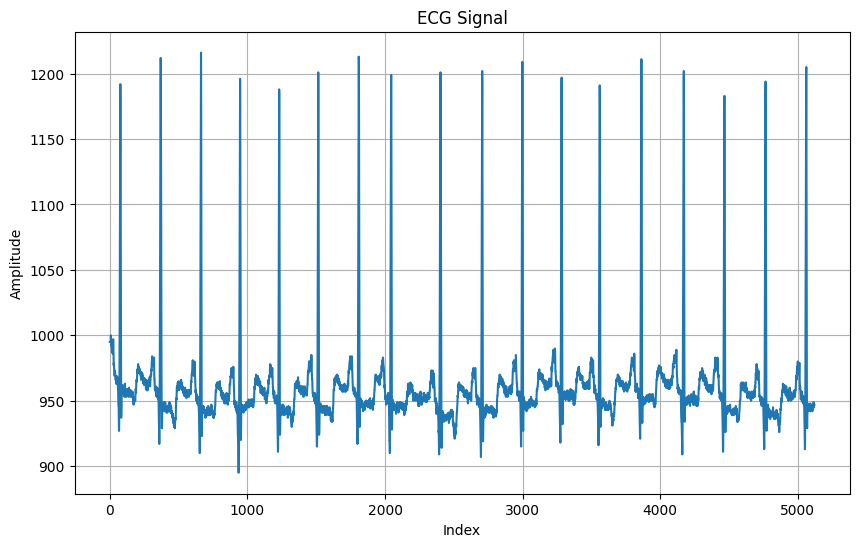

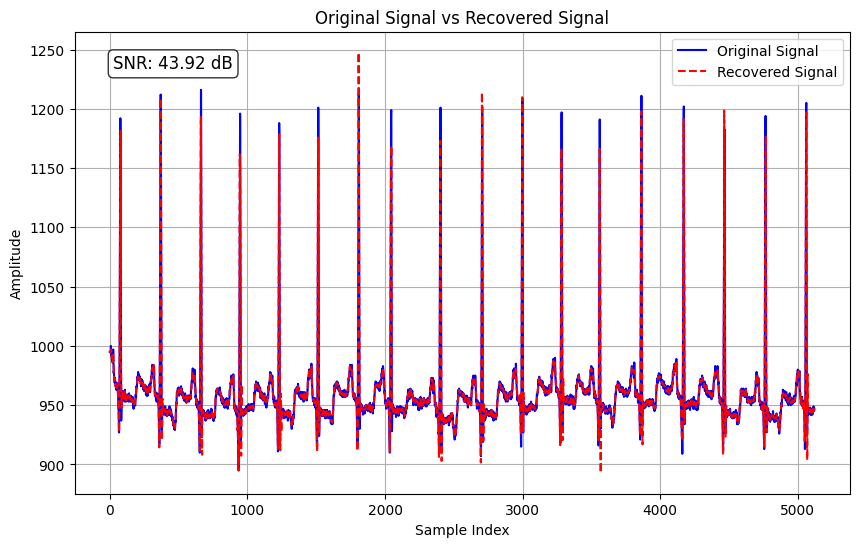

SNR: 43.91570442536586 dB


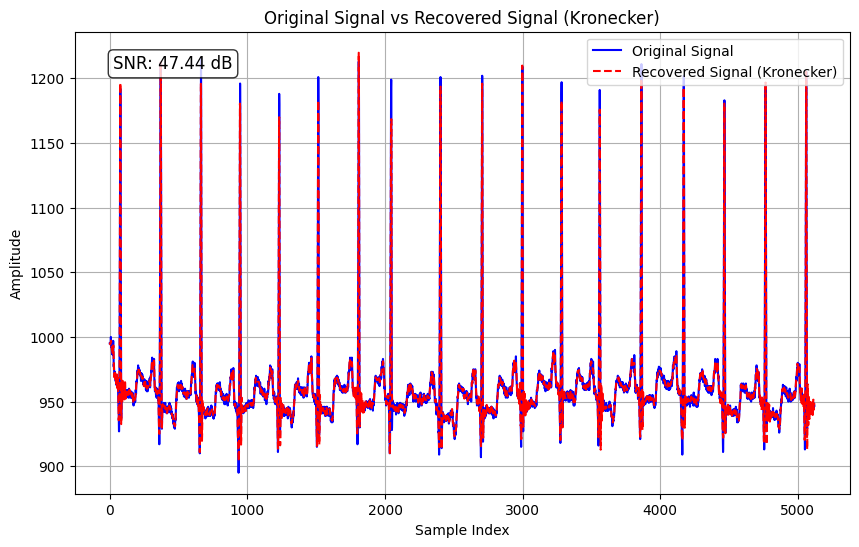

SNR (Kronecker): 47.439855787701966 dB


In [26]:
import scipy.io
import matplotlib.pyplot as plt

if __name__ == "__main__":

    # DEBUGGING PURPUSES
    import os
    # Directory where you want to save the CSV file
    output_dir = 'debugCsvPy'  # global var that refers to the directory where the CSV file will be saved
    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)


    # I put this here because you have to decide kron fact based on
    # the signal length, but for testing reasons I prefer to do the 
    # opposite: choose signal length based on kron factor
    n_block = 16 # block size, deafult is 16
    kron_factor = n_block * 2  # kron factor default is 32


    ### PREPARE
    # ----------------------------------------------------------------

    ## DATA
    #  upload data
    data = scipy.io.loadmat('100m.mat')
    # retrieve the key to a string
    key = list(data.keys())[0]
    # retrieve the values
    signal = data[key][0,:]  # [0 or 1, 0:650000] s.t. first dim: (0 is MLII, 1 is V5)
    num = 10  # how many kronecker blocks will be long the original signals
    temp = n_block * kron_factor  # this is equal to the length of a kronecker block
    start = int(temp * 0)  # choose where to start our signal in the record (signal is a piece of the record)
    end = int(start + temp * num)
    signal = signal[start:end]  # comment out to use the whole signal
    # print the shape of the signal
    print(f'Signal shape: {signal.shape}') 
    # plot the signal
    plt.figure(figsize=(10, 6))
    plt.plot(signal)
    plt.title('ECG Signal')
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()    

    # DEBUGGING
    # save the matrix to a CSV file
    np.savetxt(os.path.join(output_dir, 'signal.csv'), signal, delimiter=',', fmt='%.6f')


    ## PARAMETERS
    # compression ratio
    CR = 1/4 
    # non-kronecker
    #n_block = 16 # block size`
    m_block = int(n_block * CR) # compressed block size
    # kronecker
    #kron_factor = 32  # kron factor
    n_block_kron = n_block * kron_factor  # kron block size
    m_block_kron = int(n_block_kron * CR) # compressed kron block size
    



    ### SAMPLING PHASE 
    # ----------------------------------------------------------------


    ## MEASUREMENT MATRIX
    # generate the measurement matrix
    Phi = generate_DBDD_matrix(m_block, n_block)
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='gaussian')
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='scaled_binary')
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='unscaled_binary')


    # DEBUGGING
    # save the matrix to a CSV file
    np.savetxt(os.path.join(output_dir, 'A_Phi.csv'), Phi, delimiter=',', fmt='%.6f')


    ## COMPRESS THE SIGNAL
    # compress the signal
    Y = compressSignal(signal, Phi)

    # DEBUGGING
    # save the matrix to a CSV file
    np.savetxt(os.path.join(output_dir, 'Y.csv'), Y, delimiter=',', fmt='%.6f')



    ### RECOVERY PHASE
    # ----------------------------------------------------------------


    ## SL0 PARAMETERS
    sigma_off = 0.001  # offset for sigma
    mu_0 = 2  # scaling factor for mu
    sigma_decrease_factor = 0.5  # factor for decreasing sigma
    L = 3  # number of iterations for the inner loop
    if sigma_off > 0:
        sigma_min = sigma_off * 4  # minimum value of sigma
    else:
        sigma_min = 0.00001  # minimum value of sigma



    ## RECOVERY non-KRONECKER
    # recover the signal
    recovered_signal = non_kron_recovery(Y=Y, sigma_min=sigma_min, Phi=Phi, sigma_decrease_factor=sigma_decrease_factor,
                                            mu_0=mu_0, L=L, showProgress=False)
    

    ## RECOVERY KRONECKER
    # recover the signal

    recovered_signal_kron = kron_recovery(Y=Y, sigma_min=sigma_min, Phi=Phi, sigma_decrease_factor=sigma_decrease_factor,
                                            mu_0=mu_0, L=L, showProgress=False, kron_factor=kron_factor)
    




    ### EVALUATION
    # ----------------------------------------------------------------


    ## PLOT
    # plot the signals
    plot_signals(signal, recovered_signal, original_name="Original Signal", reconstructed_name="Recovered Signal")

    ## SNR
    # calculate the SNR
    snr = calculate_snr(signal, recovered_signal)
    print(f'SNR: {snr} dB')

    ## PLOT KRON
    # plot the signals
    plot_signals(signal, recovered_signal_kron, original_name="Original Signal", reconstructed_name="Recovered Signal (Kronecker)")
    

    ## SNR KRON
    # calculate the SNR
    snr_kron = calculate_snr(signal, recovered_signal_kron)
    print(f'SNR (Kronecker): {snr_kron} dB')



#### Check if variables are the same as the ones in MATLAB
During the run all major variables and vectors were saved as csv, the same is done in the MATLAB code, so that we can compare them. This was especially helpful to find bugs.

In [27]:
import os
import pandas as pd
import numpy as np

def compare_csv_matrices(dir1, dir2):
    # List CSV files in both directories
    files_dir1 = set(f for f in os.listdir(dir1) if f.endswith('.csv'))
    files_dir2 = set(f for f in os.listdir(dir2) if f.endswith('.csv'))
    
    # Find common files
    common_files = files_dir1.intersection(files_dir2)
    
    # Report if any files are missing in either directory
    missing_in_dir1 = files_dir2 - files_dir1
    missing_in_dir2 = files_dir1 - files_dir2
    
    if missing_in_dir1:
        print(f"Files missing in {dir1}: {', '.join(missing_in_dir1)}")
    if missing_in_dir2:
        print(f"Files missing in {dir2}: {', '.join(missing_in_dir2)}")
    
    # Compare contents of common files
    mismatches = []
    for filename in common_files:
        path1 = os.path.join(dir1, filename)
        path2 = os.path.join(dir2, filename)
        
        # Read CSV files
        df1 = pd.read_csv(path1, header=None)
        df2 = pd.read_csv(path2, header=None)
        
        # Compare as numpy arrays
        if not np.array_equal(df1.values, df2.values):
            mismatches.append(filename)
    
    # Report results
    if mismatches:
        print("Files with mismatched content:")
        for filename in mismatches:
            print(f"- {filename}")
    else:
        print("All files match!")

# Example usage
compare_csv_matrices('../debugMatlab/debugCsvMAT', './debugCsvPy')


Files with mismatched content:
- signal.csv
- Y.csv
- s_block_kron.csv
- y_concatenated.csv
- y_block.csv
- s_block.csv
